In [9]:
import sys
sys.path.append('..')
import torch
import os
import cv2
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt
import onnxruntime
from onnxruntime.capi._pybind_state import get_all_providers,get_available_providers

In [10]:
def GetRectFromRegion(region: np.array, width, height):
    x = float(width) * region[0]
    y = float(height) * region[1]
    region_width = float(width) * region[2]
    region_height = float(height) * region[3]
    return np.array([x, y, region_width, region_height], dtype=np.int)

In [11]:
LABELS = open('coco.txt').read().strip().split("\n")

In [12]:
session = onnxruntime.InferenceSession('../models/yolo3/yolov3.onnx')
image_input_name = session.get_inputs()[0].name
shape_input_name = session.get_inputs()[1].name
output_names = []
output_names.append(session.get_outputs()[0].name)
output_names.append(session.get_outputs()[1].name)
output_names.append(session.get_outputs()[2].name)

In [19]:
get_available_providers()

['CPUExecutionProvider']

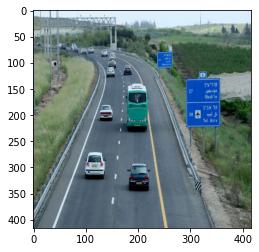

In [14]:
# img = cv2.imread('../images/1591496721867.png')
img = cv2.imread('D:/DHH/Downloads/car.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# right_mirror_region = np.array([1000.0/1920, 400.0/1080, 500.0/1920, 340.0 / 1080 ])
right_mirror_region = np.array([1620.0/1920, 90.0/1080, 275.0/1920, 360.0 / 1080 ])
rect = GetRectFromRegion(right_mirror_region, 1920, 1080)
right_mirror_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0]+rect[2]]
right_mirror_img = cv2.resize(img, (416,416))
plt.imshow(right_mirror_img)

In [15]:
import numpy as np
from PIL import Image

# this function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data


image = Image.fromarray(right_mirror_img)
# input
image_data = preprocess(image)
image_size = np.array([image.size[1], image.size[0]], dtype=np.float32).reshape(1, 2)

In [18]:
%%time
boxes, scores, indices = session.run(output_names, {image_input_name: image_data, shape_input_name: image_size})
out_boxes, out_scores, out_classes = [], [], []
for idx_ in indices:
    out_classes.append(idx_[1])
    out_scores.append(scores[tuple(idx_)])
    idx_1 = (idx_[0], idx_[2])
    out_boxes.append(boxes[idx_1])

Wall time: 183 ms


In [8]:
image_size

array([[416., 416.]], dtype=float32)

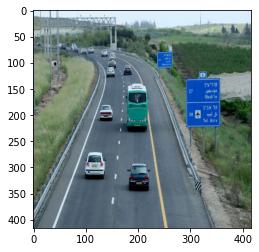

In [9]:
plt.imshow(right_mirror_img)

In [10]:
LABELS[out_classes[0]]

'car'

In [12]:
label_img = right_mirror_img.copy()

for i in range(len(out_classes)):
    (x, y) = (int(out_boxes[i][1]), int(out_boxes[i][0]))
    (w, h) = (out_boxes[i][3], out_boxes[i][2])
    cv2.putText(label_img, LABELS[out_classes[i]], (x, y),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
    cv2.rectangle(label_img, (x, y), (w, h), (255,255,255))

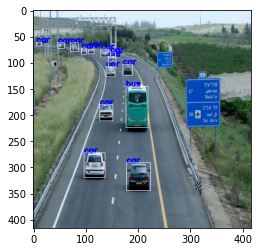

In [13]:
plt.imshow(label_img)

In [ ]:
while(1):
    cv2.imshow("result", label_img)
    if cv2.waitKey(1) == 27:
        break

In [ ]:
out_boxes


In [ ]:
x = 